# Tutorial: Spectra Analysis with Alpaga

In [1]:
#jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True tutorial_spectra_analysis.ipynb

%reset -f
import importlib
import numpy as np
import os 
import pickle
import sys

import matplotlib
import matplotlib.pyplot as plt

import Alpaga # the full package
from Alpaga import file_management
from Alpaga import analyze_run
from Alpaga.Data_tutorial import get_tutorial_path 


## Introduction

In this tutorial, we will see how to analyze your raw spectra to extract the second harmonic intensity (or any Gaussian-shaped peak).

We will assume that one experiment is composed of a series of spectra where one physical parameter is changed (**angle**). For each angle, several spectra acquisitions can be performed, which we call **iterations**. We assume that the number of iterations is the same for all angles.

The spectra are saved in files. The way Alpaga performs the link between the angle value and iteration number is discussed in the `tutorial_file_management` notebook. Please have a look at that tutorial before doing this one.

### Tutorial Structure

This tutorial is structured as follows:
1. **Clean and average the spectra** - Remove artifacts and combine iterations
2. **Extract the Gaussian intensity** - Fit peaks and remove noise
3. **Present the automated procedure** - Complete workflow
4. **Discuss one example** - Real case study


### Prerequisites

Before starting, make sure you understand:
- File naming conventions (see `tutorial_file_management`)  
- Basic concepts: **angle** (varying parameter) and **iteration** (repeated measurements)
- Your data organization and file paths

# I. Cleaning and Averaging

During the cleaning and averaging, we will get rid of the raw file associations. Hence, this is the part where you will get rid of the naming convention issues that you may have.

> **Note**: For more information about how the cleaning is done, read the documentation wiki.

## I.A Standard Naming Convention

For each angle (or for all samples if you have only one angle), you can remove the spikes and average over all the iterations available using the `alpaga.averaging_and_cleaning` function.

### Function Parameters

**Inputs:**
- `names`: File names pattern - should be "directory + prefix"  
- `N_iter`: Number of iterations (if not specified, uses the value found in the previous part; you can select only some iterations by writing `N_iter=[1, 10]` for example)
- `L_mean_cleaning_n`, `L_mean_cleaning_evo_max`: Cleaning parameters (see documentation for details)
- `show_spectra`: 
  - `'all'` to see each treated spectrum (to adjust cleaning parameters)
  - `'average'` to see only the averaged spectrum
  - `False` to show no plots

**Outputs:**
- `L_lambda`: Contains the wavelength values
- `L_spectra`: Contains the cleaned and averaged spectrum over the `N_iter` available spectra

### Basic Usage Example

We will use data stored in the tutorial directory. These data have been recorded using our standard naming convention (defined using `Alpaga.file_management.standard_file_name`). Hence, we can directly "read" the directory where these data are stored using `Alpaga.file_management.find_angle_iter_from_dir`.

In [2]:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)
print("prefix_file=", prefix_file)
print("L_files_angles=", L_files_angles)
print("N_iter=", N_iter)
print("extension=", extension)

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
prefix_file= Spectre
L_files_angles= ['4.0', '8.0', '12.0', '16.0', '20.0', '24.0', '28.0', '32.0', '36.0', '40.0', '44.0', '48.0', '52.0', '56.0', '60.0', '64.0', '68.0', '72.0', '76.0', '80.0', '84.0', '88.0', '92.0', '96.0', '100.0', '104.0', '108.0', '112.0', '116.0', '120.0', '124.0', '128.0', '132.0', '136.0', '140.0', '144.0', '148.0', '152.0', '156.0', '160.0', '164.0', '168.0', '172.0', '176.0', '180.0', '184.0', '188.0']
N_iter= 12
extension= .dat


### File Reference Example

In [3]:
myangle= L_files_angles[5] # [5] targets the 6th element 
nbriter = str(5) # should be string and below N_iter

print("prefix_file=", prefix_file)
print("myangle=", myangle)
print("nbriter=", nbriter)
print("extension=", extension)
print("name of the file=", Alpaga.file_management.standard_file_name(prefix_file, angle=myangle, iteration=nbriter, extension=extension))


prefix_file= Spectre
myangle= 24.0
nbriter= 5
extension= .dat
name of the file= Spectre_24.0_5.dat


### Cleaning Procedure

In this context, we can call directly the `averaging_and_cleaning` function. This function works for a given angle, here for instance the first one:

Averaging will be done for iterations from 1 to 12
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_7.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_8.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_9

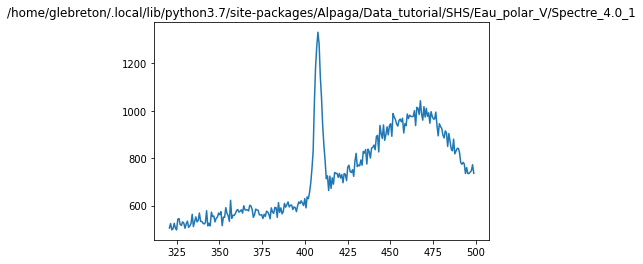

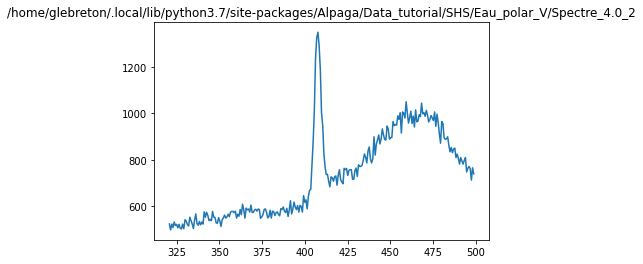

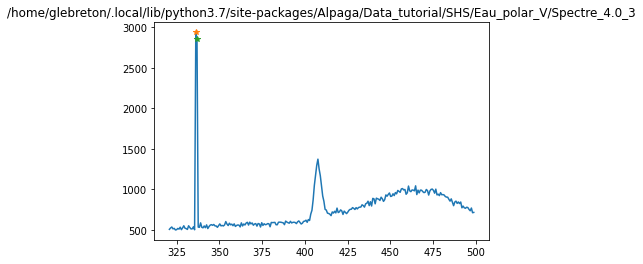

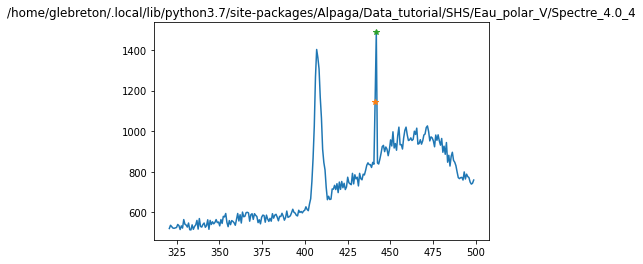

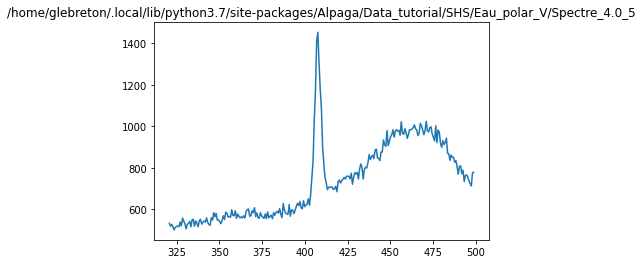

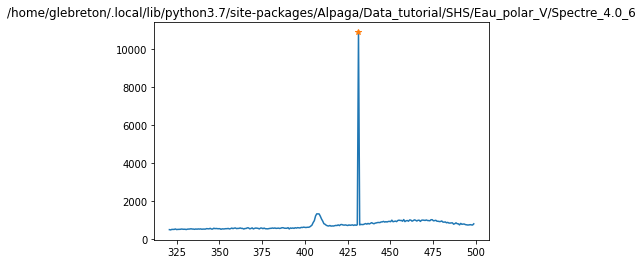

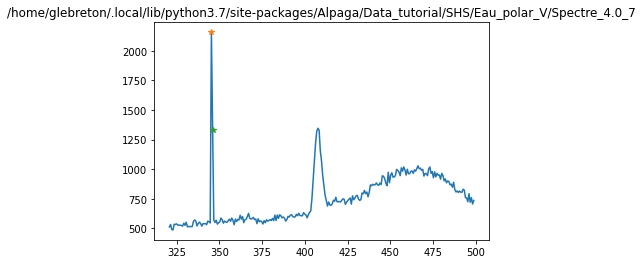

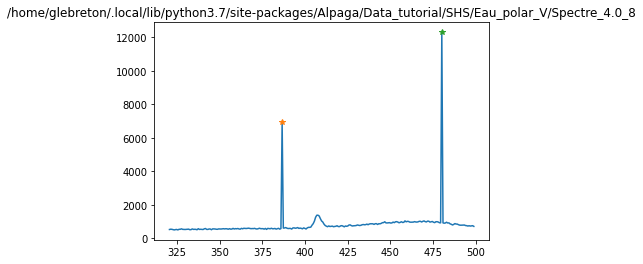

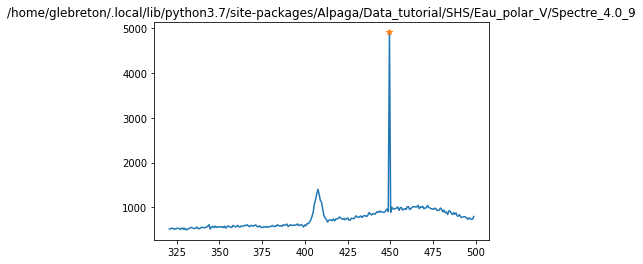

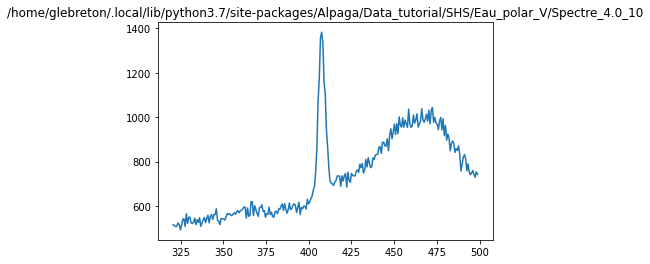

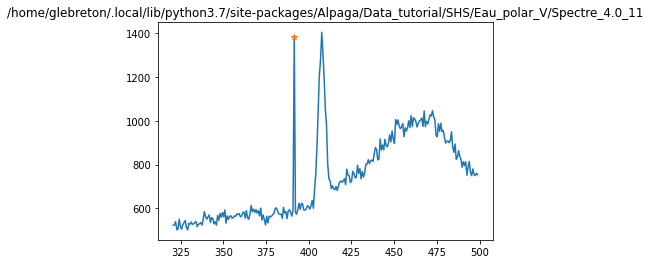

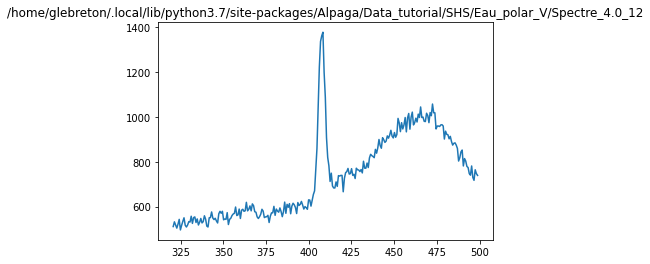

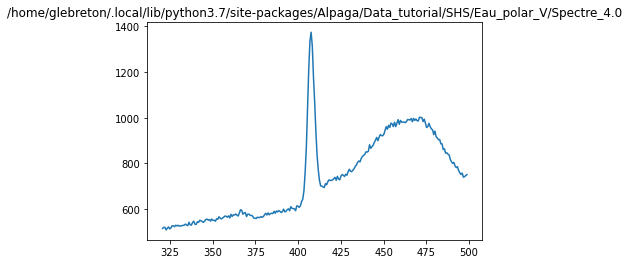

In [4]:
# The cleaning procedure should be called for a single angle at a time
directory = get_tutorial_path("SHS/Eau_polar_V")
names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

# You are giving a function as argument here: 
fct_name = Alpaga.file_management.standard_file_name  # Links names + iteration + extension to file

# Cleaning parameters (see documentation for details)
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3]

# Perform cleaning and averaging
L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(
    names, N_iter, 
    extension='.dat', 
    fct_name=fct_name, 
    type_cleaning='mean', 
    L_mean_cleaning_n=L_mean_cleaning_n, 
    L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
    show_spectra='all', 
    figure_counter=1
)


**Important Notes:**
- `names` should be: `directory + prefix`
- `N_iter` here is the number of iterations found in the previous part (here 12)
- `L_lambda` contains the wavelength values
- `L_spectra` contains the cleaned and averaged spectrum over the `N_iter` available spectra


### Advanced Usage: Selective Averaging

If you want to average over only some iterations, set `N_iter` to a list of the iterations you want to average. For instance, to average over iterations 1 and 10:

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
Averaging will be done for iterations: [1, 10]
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_10.dat


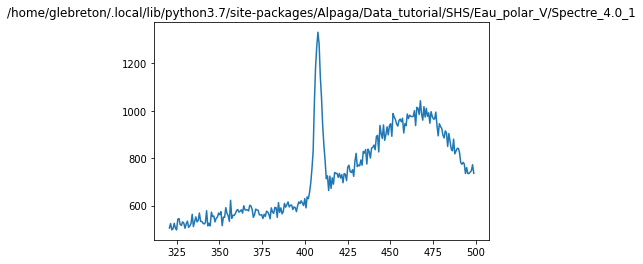

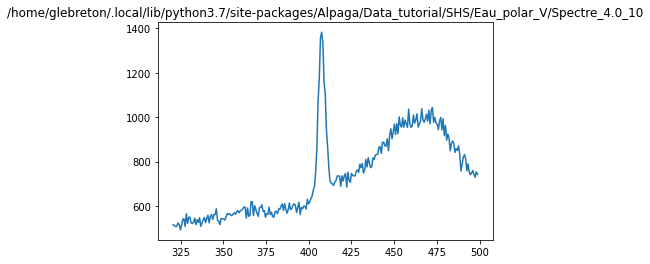

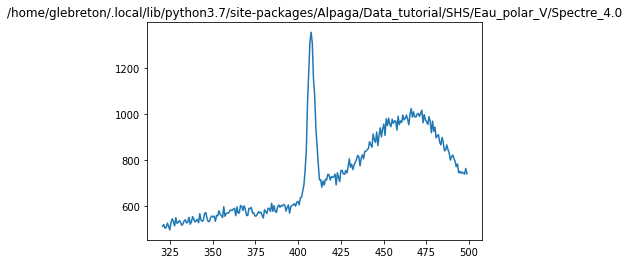

In [5]:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)
names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0] 

N_iter = [1, 10]
L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', figure_counter=1)

### Single Spectrum Processing

If you want to only clean (not average) the spectra, use a list with one single element:

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
Averaging will be done for iterations: [2]
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat


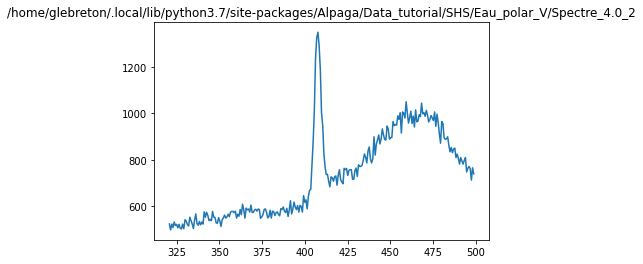

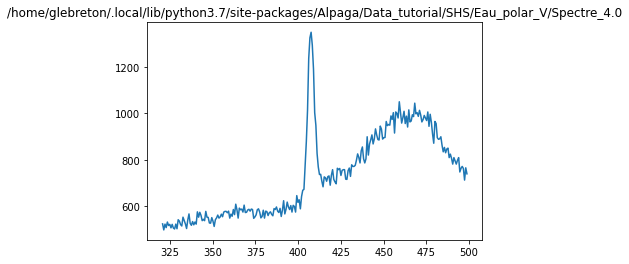

In [6]:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)

names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

N_iter = [2]

L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', figure_counter=1)

## I.B Custom Naming Convention

Let's say you have a different naming convention, but it is close enough to stay within the Alpaga "framework". Define your own naming convention function:

In [7]:
def my_convention_file_name(prefixe, angle=False, iteration=False, extension='.dat'):
    '''
    This is in fact the Alpaga.file_management.standard_file_name function because we are dealing with the same data. 
    For your data, change the lines with the # change here  
    '''
    if isinstance(angle, bool):
        if isinstance(iteration, bool):
            name = prefixe + extension # change here 
        else:
            name = prefixe + '_' + iteration + extension # change here 
    else:
        if isinstance(iteration, bool):
            name = prefixe + '_' + angle + extension # change here 
        else: 
            name = prefixe + '_' + angle + '_' + iteration + extension # change here 
    return(name)

And check it: 

In [8]:
prefix_file = 'Spectre' # this should be define in function of your datas
L_files_angles = ['4.0', '12.0', '24.0'] # this should be define in function of your datas
N_iter = 5 # this should be define in function of your datas
extension = '.dat' # this should be define in function of your datas


myangle = L_files_angles[1] # [1] targets the 2nd element 

print("prefix_file=", prefix_file)
print("myangle=", myangle)
print("nbriter=", nbriter)
print("extension=", extension)
print("name of the file=", my_convention_file_name(prefix_file, angle=myangle, iteration=str(N_iter), extension=extension))


prefix_file= Spectre
myangle= 12.0
nbriter= 5
extension= .dat
name of the file= Spectre_12.0_5.dat


### Using Custom Convention

Again, in this example we are using the same naming convention, but in principle, you can use another convention with your function `my_convention_file_name`. To perform the cleaning, use:

Averaging will be done for iterations from 1 to 5
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat


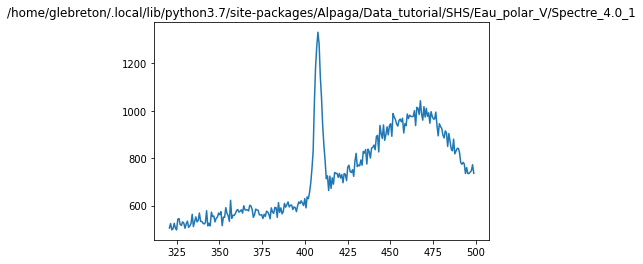

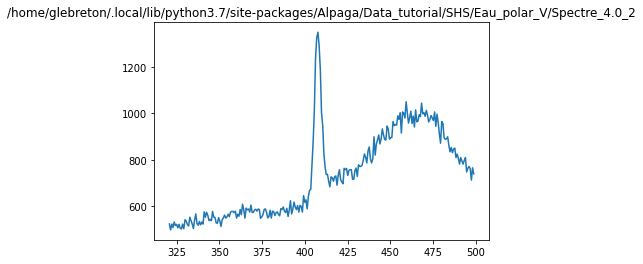

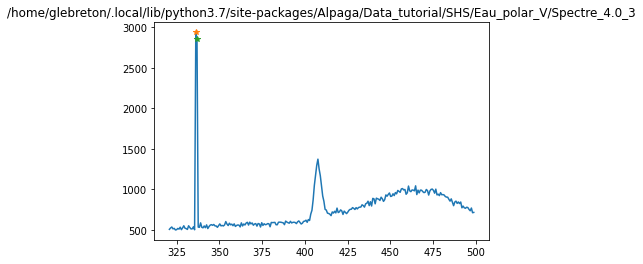

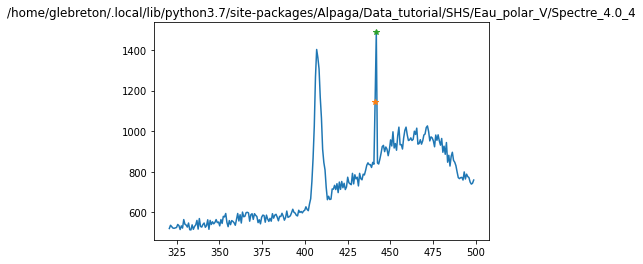

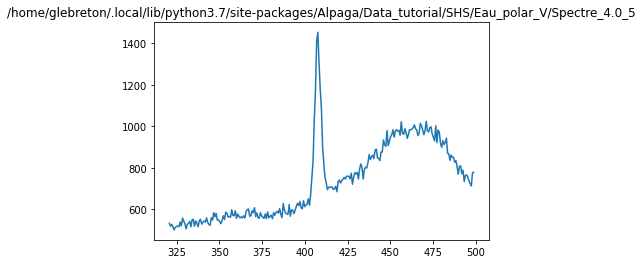

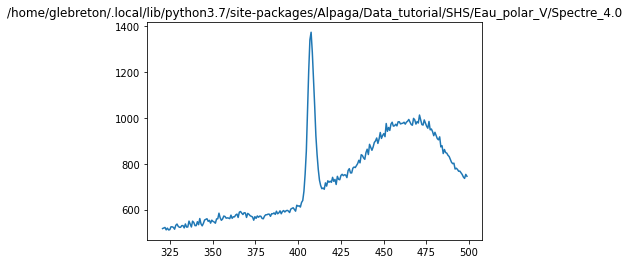

In [9]:
prefix_file = 'Spectre' # this should be define in function of your datas
L_files_angles = ['4.0', '12.0', '24.0'] # this should be define in function of your datas
N_iter = 5 # this should be define in function of your datas
extension = '.dat' # this should be define in function of your datas

# The cleaning procedure should be called for a single angle at a time:
directory = get_tutorial_path("SHS/Eau_polar_V")
names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

# Your are giving a function as argument here: 
fct_name = my_convention_file_name # The function linking the names + iteration number + extension to the file


L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', 
                                                                   fct_name=fct_name, 
                                                                   type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                   L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', 
                                                                   figure_counter=1)


> **Note**: You will be able to call the automated procedure using your custom naming convention function.


## I.C Manual File List (Advanced)

If using a custom naming function is not possible, then you should provide to `Alpaga.analyze_run.averaging_and_cleaning` a list of the filenames to treat. For instance:

In [10]:
directory = get_tutorial_path("SHS/Eau_polar_V")
L_filename = ['Spectre_4.0_1.dat', 'Spectre_4.0_2.dat', 'Spectre_4.0_3.dat']
L_filename = [directory + '/' + L_filename[k] for k in range(len(L_filename))]
print(L_filename)


['/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat', '/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat', '/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat']


Then call the function by adding the extra argument `L_filename` (you can define or not `extension` and `fct_name`, they will not be used anyway):

Averaging will be done for iterations from 1 to 3
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat


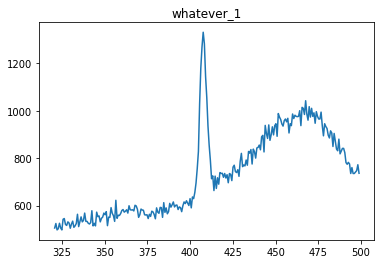

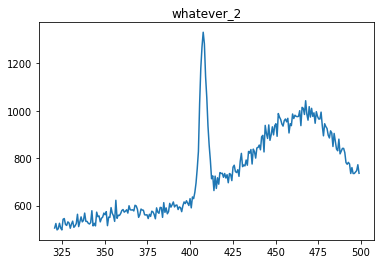

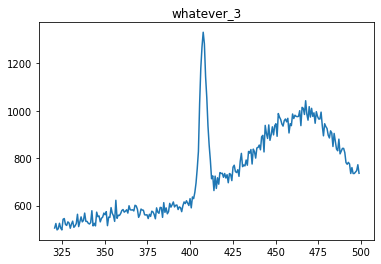

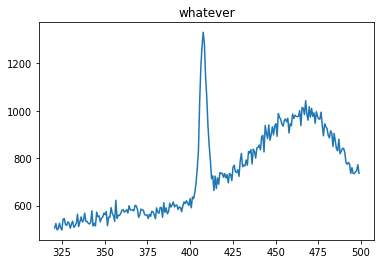

In [11]:
directory = get_tutorial_path("SHS/Eau_polar_V")
names = 'whatever' # this argument has no use here
L_filename = ['Spectre_4.0_1.dat', 'Spectre_4.0_2.dat', 'Spectre_4.0_3.dat']
L_filename = [directory + '/' + L_filename[k] for k in range(len(L_filename))]
N_iter = 3

L_mean_cleaning_n = [1, 1, 1, 3] # see wiki 
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] # see wiki 

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, 
                                                                   L_filename=L_filename,
                                                                   extension='.dat', 
                                                                   type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                   L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra='all', 
                                                                   figure_counter=1)

## Summary of Part I


| **Method** | **Use Case** | **Key Parameters** |
|------------|--------------|-------------------|
| **Standard** | Files follow `prefix_angle_iteration.extension` | Use `standard_file_name` |
| **Custom** | Similar pattern, different separators | Define `my_convention_file_name` |
| **Manual** | Completely different file organization | Provide `L_filename` list |

**Key Outputs:**
- `L_lambda`: Wavelength array
- `L_spectra`: Cleaned and averaged spectrum
- Ready for noise removal and Gaussian fitting (Part II)

**Next Steps:**
- Part II: Noise removal and Gaussian fitting
- Part III: Automated workflow for multiple angles

# II. Noise and Fit

Now that we have got ride of the "unphysical" perturbation, let us analyze the averaged spectra for a given angle. 

In the following, we will stick to the original naming convention, but you can also use another options as long as the spectra cleaning is done properly, see previous part. 

The spectra generally contains the gaussian peak that we want to study but also some noise due to fluorescence or unwanted light. We will first adjust the parameters allowing to distinguish noise from signal.
Then, we fit the signal with a Gaussian.

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_7.dat
/home/glebreton/.loca

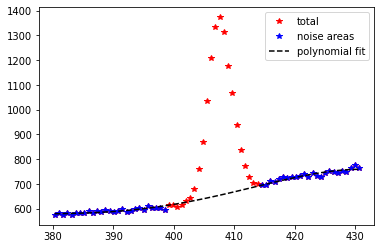

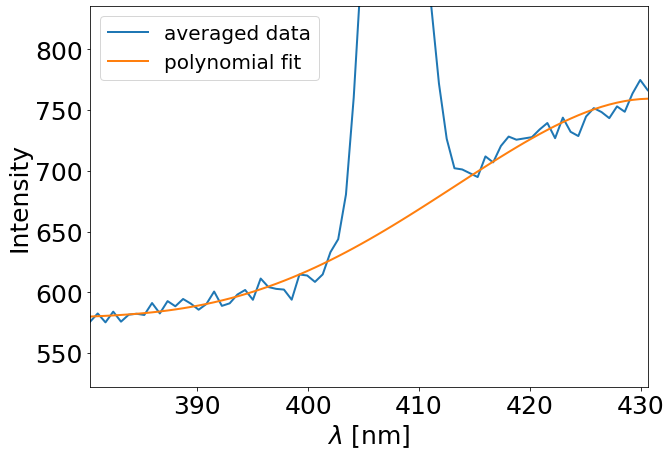

In [12]:
# To check how the noise is removed:
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)

names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.3, 1.3]

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra=False, figure_counter=1)

l_cut = [380, 399, 414, 431]
order_fit_noise = 4

L_x_cleaned, L_y_cleaned, L_y_noise_fit, x_cut, figure_counter = Alpaga.analyze_run.remove_noise(L_lambda, L_spectra, l_cut=l_cut, order_fit_noise=order_fit_noise, return_fit_noise=True, return_boundary=True, show_spectra='all', figure_counter=1)

plt.figure(figure_counter, figsize=(10, 7))
plt.plot(L_lambda, L_spectra, label='averaged data', lw=2)
plt.plot(L_x_cleaned, L_y_noise_fit, label='polynomial fit', lw=2)
plt.xlabel(r'$\lambda$ [nm]', fontsize=25)
plt.xlim([L_x_cleaned[0], L_x_cleaned[-1]])
plt.ylim([np.min(L_y_noise_fit)*0.9, np.max(L_y_noise_fit)*1.1])
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)


print('To get the position of the area, use: x_cut ', x_cut)
print('Check the target and the valued used. Used:', L_lambda[x_cut[0]],  'target (l_cut):', l_cut[0])
print('Check the target and the valued used. Used:', L_lambda[x_cut[1]],  'target (l_cut):', l_cut[1])
print('Check the target and the valued used. Used:', L_lambda[x_cut[2]],  'target (l_cut):', l_cut[2])
print('Check the target and the valued used. Used:', L_lambda[x_cut[3]],  'target (l_cut):', l_cut[3])


print(L_y_noise_fit)

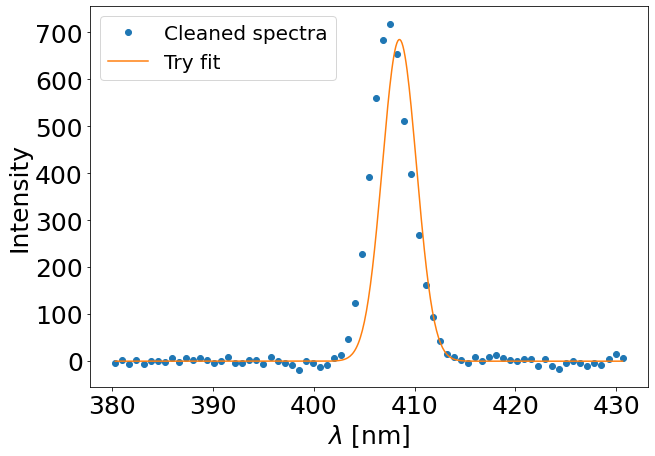

In [13]:
# humain fit: try out!
intensity = 685
lambda_0 = 408.5
omega = 2.4

L_x_for_fit = np.linspace(L_x_cleaned[0], L_x_cleaned[-1], 500)

figure_counter += 1
plt.figure(figure_counter, figsize=(10, 7))
plt.plot(L_x_cleaned, L_y_cleaned, 'o', label='Cleaned spectra', lw=2)
plt.plot(L_x_for_fit, Alpaga.analyze_run.fit_gausse(L_x_for_fit, intensity, lambda_0, omega), label='Try fit', lw=1.5)

plt.xlabel(r'$\lambda$ [nm]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)

To fit the gaussian intensity from the averaged and cleaned spectra, use the function *fit_gaussian_from_noise*: 

The inputs are:

- The 4 value of l_cut defines 3 areas in the spectrum with respect to the lambda values. The first to second the left area, and the third to last the right area and the second to third the middle area. The first and last area should be the 'noise', while the middle area should contain the gaussian and the noise. A polynomial fit is done within the left and right area, WITHOUT the midle part of the spectra, where the gaussian should be located. Therefore, try to set the first and last values where the noise is more or less ''smooth enough to be fited by a polynomial''. And the second and third value not too close to the gaussian, and not too far. Too close would reduce the intensity of the gaussian. Too far could lead to a bad noise fit within the gaussian area.
- The order of the polynom used to fit
- *bounds_fit_gausse* set the bounds parameter for the fit. The first list are the minimum and the second the maximum. The parameter are: intensity, lambda_0 and the width . Please note that you really should not increase to much the width as it would lead to bad fitting for low intensity value.  

I will look at file with the extension .dat in the directory /home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_Vfor angle dependent values. The type of the files should be: prefix_angle_iter.extension
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_4.0_7.dat
/home/glebreton/.loca

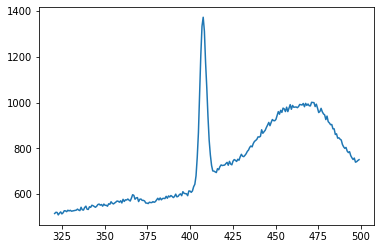

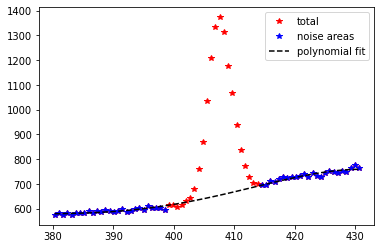

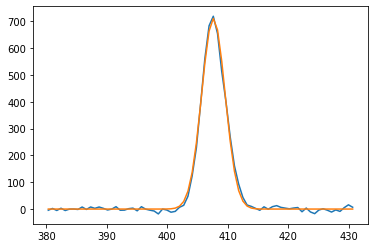

In [14]:
# The noise + gaussian fit
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file, L_files_angles, N_iter, extension = Alpaga.file_management.find_angle_iter_from_dir(directory)

names = os.path.join(directory, prefix_file) + '_' + L_files_angles[0]

L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.3, 1.3]

L_lambda, L_spectra, _ = Alpaga.analyze_run.averaging_and_cleaning(names, N_iter, extension='.dat', type_cleaning='mean', L_mean_cleaning_n=L_mean_cleaning_n, L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, show_spectra=False, figure_counter=1)

l_cut = [380, 399, 414, 431]
order_fit_noise = 4


L_para_gauss, L_err, figure_counter = Alpaga.analyze_run.fit_gaussian_from_noise(L_lambda, L_spectra, l_cut=l_cut, order_fit_noise=order_fit_noise, bounds_fit_gausse=([0, 395, 1], [np.inf, 410, 25]), show_spectra='all')

intensity, lambda_0, omega = L_para_gauss
err_intensity, err_lambda_0, err_omega = L_err
print('Intensity:',intensity,' Lambda:',lambda_0, ' Omega: ', omega)
print('Intensity err',err_intensity, 'Lambda err:', err_lambda_0, 'Omega err:', err_omega )


# III. Automatic procedure

## III.A Original naming convention

Let us present the use with the most automatization: with the original naming convention

In [15]:
# Everything is defined thanks to the Alpaga.file_management.find_angle_iter_from_dir function.
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file = False
L_files_angles = False 
N_iter = False
extension = '.dat'

# If working with the 3rd floor setup, change this function for the appropriate one, i.e. alpaga.third_floor_file_name_builder
fct_name = Alpaga.file_management.standard_file_name # For nanoptec and underground
# fct_name = alpaga.third_floor_file_name_builder # For 3rd floor

In [16]:
# Cleaning parameters:
type_cleaning='mean' # default
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] 

In [17]:
# Noise 
l_cut = [380, 399, 414, 431] # remember that you still need to define meaningfull l_cut parameter even if you use the automatic_l_cut method!!!
order_fit_noise = 4

automatic_l_cut = True
l_cut_n_n2 = [2, 9] # *w0


Several procedures are implemented to obtain the peak intensity :
    - one where the peak is fitted by a gaussian with all the parameters are free. To use this set method_fit_first='fit_gauss'
    - one where the peak is fitted by a gaussian with the central wavelength and gaussian width are fixed (to values obtained as the average value of previous procedure). To use this, set fixed_para_gauss_fit = True and method_fit_second = 'fit_gauss' 
    - one where the integral of the peak is used to exrtact the intensity (central wavelength and gaussian width fixed). To use this, set fixed_para_gauss_fit = True and method_fit_second = 'integral_gauss' 
    
If fixed_para_gauss_fit = True, Alpaga will run 2 times: one to compute the intensity for each polarization angle with free parameters, and another run where lambda_0 and omega_0 are fixed. 

In [18]:
# Fit the gaussian parameters:
bounds_fit_gausse=([0, 404, 1], [np.inf, 410, 3])
lambda_0_ref = 407.7 # useless if you use method_fit_first='fit_gauss'
waist_ref = 2.52

method_fit_first='fit_gauss' # 'integral_gauss' or 'fit_gauss'

fixed_para_gauss_fit = True
method_fit_second = 'both' # or integral_gauss' or 'fit_gauss' or 'both'


In [19]:
# Saving the results:
save_result=False
name_save_result = os.path.join("Yourpath", 'post_prod_results.p')

During the procedure, several graphs will be plotted for each polarization angle: 

- if automatic_l_cut = False

    + The averaged spectra cleaned from the spikes
    
    + The definition of the noise and signal area
    
    + The averaged spectra with the backround removed and the Gaussian fit
    
- automatic_l_cut = True

    + The same 3 plots 
    
    + The averaged spectra cleaned from the spikes (again)
    
    + The definition of the noise and signal area with the automatic definition
    
    + The averaged spectra cleaned from the spikes with this automatic definition of the noise
    
    
Then, if fixed_para_gauss_fit = True, a second run is performed over all the polarization angles.

In [20]:
# waiting_time = False # False or a float
waiting_time = 0 # for instance use this to make Alpaga waits 5 sec between each polarization angle analysis. Doing so, you have more time to check that the fit procedure works.

Second Run, Angle: 188.0
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_5.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_6.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_7.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_8.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_188.0_9.dat
/ho

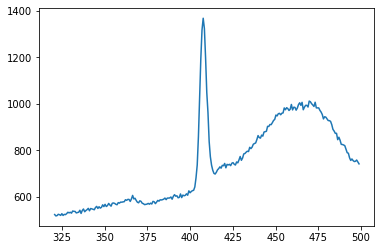

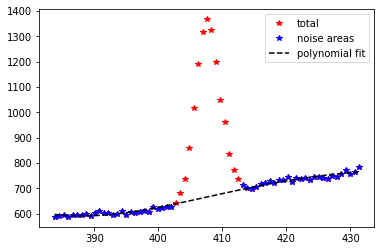

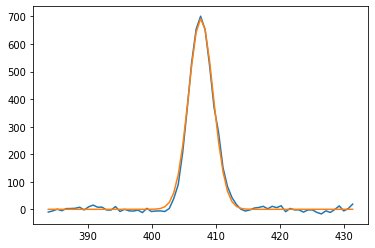

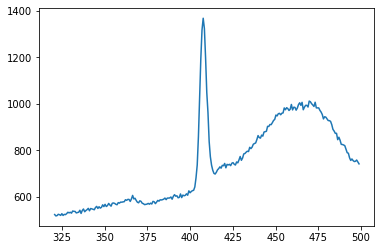

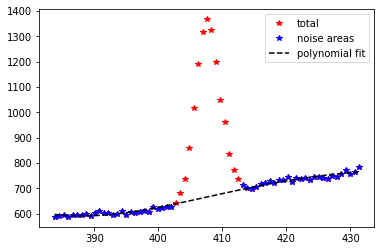

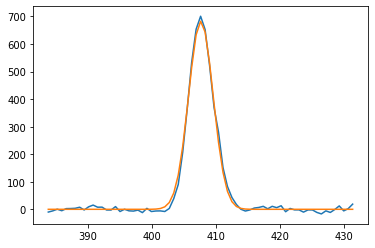

The results are not saved. Set save_result to True if you want to save them.


In [21]:
# The line to make the run: do not change anything here: all the parameter are defined above!
L_post_prod_gauss_fit_integral = Alpaga.analyze_run.polarisation_intensity(directory=directory, 
                                                                           prefix_file=prefix_file, 
                                                                           L_files_angles=L_files_angles, 
                                                                           N_iter=N_iter, 
                                                                           extension=extension, 
                                                                           fct_name=fct_name, 
                                                                           type_cleaning=type_cleaning, 
                                                                           L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                           L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
                                                                           automatic_l_cut=automatic_l_cut, 
                                                                           l_cut=l_cut, 
                                                                           l_cut_n_n2=l_cut_n_n2, 
                                                                           order_fit_noise=order_fit_noise, 
                                                                           method_fit_first=method_fit_first, 
                                                                           bounds_fit_gausse=bounds_fit_gausse, 
                                                                           lambda_0_ref=lambda_0_ref, 
                                                                           waist_ref=waist_ref, 
                                                                           fixed_para_gauss_fit=fixed_para_gauss_fit, 
                                                                           method_fit_second=method_fit_second, 
                                                                           save_result=save_result, 
                                                                           name_save_result=name_save_result, 
                                                                           waiting_time=waiting_time)


## III.B Very close naming convention

Just modify the fct_name. However, you will have to provide the prefix_file, L_files_angles, N_iter and extension.

In [22]:
def my_convention_file_name(prefixe, angle=False, iteration=False, extension='.dat'):
    '''
    This is in fact the Alpaga.file_management.standard_file_name function because we are dealing with the same data. 
    For your data, change the lines with the # change here  
    '''
    if isinstance(angle, bool):
        if isinstance(iteration, bool):
            name = prefixe + extension # change here 
        else:
            name = prefixe + '_' + iteration + extension # change here 
    else:
        if isinstance(iteration, bool):
            name = prefixe + '_' + angle + extension # change here 
        else: 
            name = prefixe + '_' + angle + '_' + iteration + extension # change here 
    return(name)
directory = get_tutorial_path("SHS/Eau_polar_V")
prefix_file = 'Spectre' # this should be define in function of your datas
prefix_file = os.path.join(directory, prefix_file)
L_files_angles = ['4.0', '12.0', '24.0'] # this should be define in function of your datas
N_iter = 5 # this should be define in function of your datas
extension = '.dat' # this should be define in function of your datas


# If working with the 3rd floor setup, change this function for the appropriate one, i.e. alpaga.third_floor_file_name_builder
fct_name = my_convention_file_name # For nanoptec and underground
# fct_name = alpaga.third_floor_file_name_builder # For 3rd floor

In [23]:
# Cleaning parameters:
type_cleaning='mean' # default
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] 

# Noise 
l_cut = [380, 399, 414, 431] # remember that you still need to define meaningfull l_cut parameter even if you use the automatic_l_cut method!!!
order_fit_noise = 4

automatic_l_cut = True
l_cut_n_n2 = [2, 9] # *w0


# Fit the gaussian parameters:
bounds_fit_gausse=([0, 404, 1], [np.inf, 410, 3])
lambda_0_ref = 407.7 # useless if you use method_fit_first='fit_gauss'
waist_ref = 2.52

method_fit_first='fit_gauss' # 'integral_gauss' or 'fit_gauss'

fixed_para_gauss_fit = True
method_fit_second = 'both' # or integral_gauss' or 'fit_gauss' or 'both'


# Saving the results:
save_result=False
name_save_result = os.path.join("SomePath", 'post_prod_results.p')
waiting_time = 0

Second Run, Angle: 24.0
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_2.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_3.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_4.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_24.0_5.dat


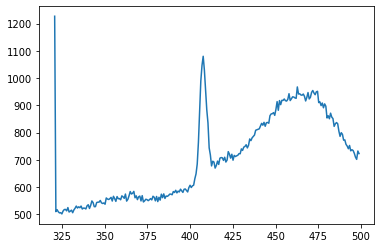

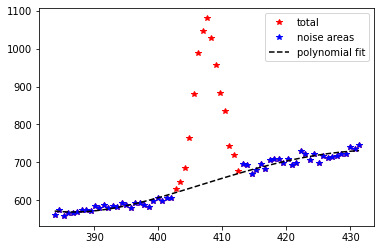

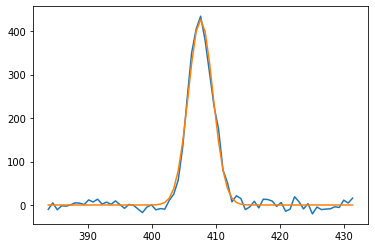

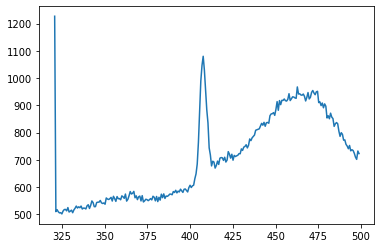

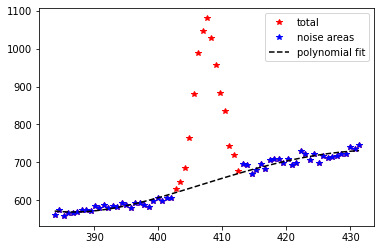

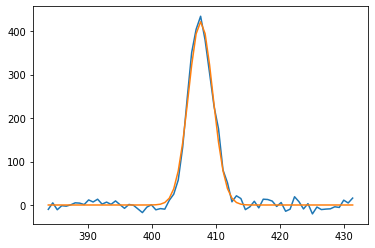

The results are not saved. Set save_result to True if you want to save them.


In [24]:
# The line to make the run: do not change anything here: all the parameter are defined above!
L_post_prod_gauss_fit_integral = Alpaga.analyze_run.polarisation_intensity(directory=False, 
                                                                           prefix_file=prefix_file, 
                                                                           L_files_angles=L_files_angles, 
                                                                           N_iter=N_iter, 
                                                                           extension=extension, 
                                                                           fct_name=fct_name, 
                                                                           type_cleaning=type_cleaning, 
                                                                           L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                           L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
                                                                           automatic_l_cut=automatic_l_cut, 
                                                                           l_cut=l_cut, 
                                                                           l_cut_n_n2=l_cut_n_n2, 
                                                                           order_fit_noise=order_fit_noise, 
                                                                           method_fit_first=method_fit_first, 
                                                                           bounds_fit_gausse=bounds_fit_gausse, 
                                                                           lambda_0_ref=lambda_0_ref, 
                                                                           waist_ref=waist_ref, 
                                                                           fixed_para_gauss_fit=fixed_para_gauss_fit, 
                                                                           method_fit_second=method_fit_second, 
                                                                           save_result=save_result, 
                                                                           name_save_result=name_save_result, 
                                                                           waiting_time=waiting_time)


## III.C Different naming convention

If you are using a whole different way of naming / saving the spectra, you should provide the full path of each acquisition as a N_angle x N_iter list. Then, add the optional argument L_filename. 

In [25]:
directory = get_tutorial_path("SHS/Eau_polar_V")
names = 'whatever' # this argument has no use here
L_files_angles = ['4', '8', '12']
N_iter = 3 
# you really want to define a for loop to define this: 
L_filename_local = [
['Spectre_4.0_1.dat', 'Spectre_4.0_2.dat', 'Spectre_4.0_3.dat'],
['Spectre_8.0_1.dat', 'Spectre_8.0_2.dat', 'Spectre_8.0_3.dat'],    
['Spectre_12.0_1.dat', 'Spectre_12.0_2.dat', 'Spectre_12.0_3.dat']
]
L_filename = []
for i in range(len(L_files_angles)):
    L_filename.append([directory + '/' + L_filename_local[i][k] for k in range(N_iter)])


In [26]:
# Cleaning parameters:
type_cleaning='mean' # default
L_mean_cleaning_n = [1, 1, 1, 3]
L_mean_cleaning_evo_max = [2, 1.5, 1.4, 1.3] 

# Noise 
l_cut = [380, 399, 414, 431] # remember that you still need to define meaningfull l_cut parameter even if you use the automatic_l_cut method!!!
order_fit_noise = 4

automatic_l_cut = True
l_cut_n_n2 = [2, 9] # *w0


# Fit the gaussian parameters:
bounds_fit_gausse=([0, 404, 1], [np.inf, 410, 3])
lambda_0_ref = 407.7 # useless if you use method_fit_first='fit_gauss'
waist_ref = 2.52

method_fit_first='fit_gauss' # 'integral_gauss' or 'fit_gauss'

fixed_para_gauss_fit = True
method_fit_second = 'both' # or integral_gauss' or 'fit_gauss' or 'both'


# Saving the results:
save_result=False
name_save_result = os.path.join("SomePath", 'post_prod_results.p')
waiting_time = 0

Second Run, Angle: 12
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_12.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_12.0_1.dat
/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/Spectre_12.0_1.dat


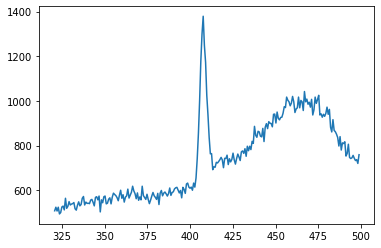

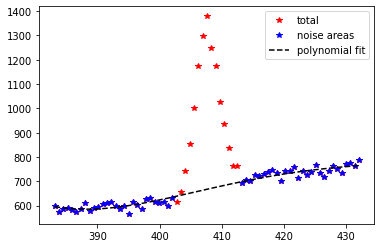

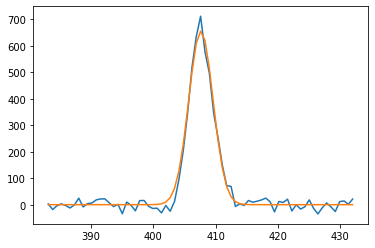

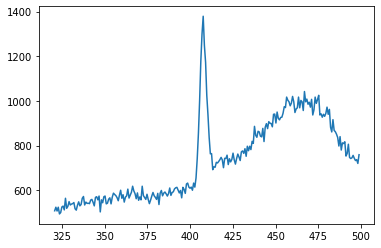

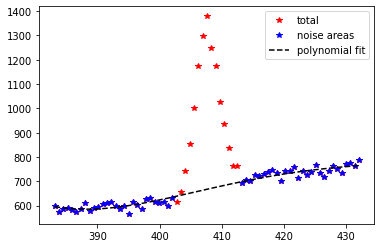

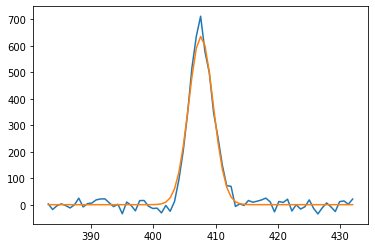

The results are not saved. Set save_result to True if you want to save them.


In [27]:
# The line to make the run: do not change anything here: all the parameter are defined above!
L_post_prod_gauss_fit_integral = Alpaga.analyze_run.polarisation_intensity(directory=False, 
                                                                           L_filename=L_filename, 
                                                                           L_files_angles=L_files_angles, 
                                                                           N_iter=N_iter, 
                                                                           type_cleaning=type_cleaning, 
                                                                           L_mean_cleaning_n=L_mean_cleaning_n, 
                                                                           L_mean_cleaning_evo_max=L_mean_cleaning_evo_max, 
                                                                           automatic_l_cut=automatic_l_cut, 
                                                                           l_cut=l_cut, 
                                                                           l_cut_n_n2=l_cut_n_n2, 
                                                                           order_fit_noise=order_fit_noise, 
                                                                           method_fit_first=method_fit_first, 
                                                                           bounds_fit_gausse=bounds_fit_gausse, 
                                                                           lambda_0_ref=lambda_0_ref, 
                                                                           waist_ref=waist_ref, 
                                                                           fixed_para_gauss_fit=fixed_para_gauss_fit, 
                                                                           method_fit_second=method_fit_second, 
                                                                           save_result=save_result, 
                                                                           name_save_result=name_save_result, 
                                                                           waiting_time=waiting_time)


# IV: Example of use, load results and plot:

In [28]:
directory = get_tutorial_path("SHS/Eau_polar_V")
name_save_result = os.path.join(directory, 'post_prod_results.p')

print(name_save_result)

with open(name_save_result, "rb") as filetoload:
    L_post_prod_load = pickle.load(filetoload)

L_files_angles = L_post_prod_load['L_files_angles']

L_files_angles_new = []
for k in range(0, len(L_files_angles), 1):
    L_files_angles_new.append(float(L_files_angles[k]))
L_polarisation_angle = np.array(L_files_angles_new)*2

L_intensity = L_post_prod_load['L_intensity']
L_intensity_error = L_post_prod_load['L_intensity_error']
L_lambda_0 = L_post_prod_load['L_lambda_0']
L_lambda_0_error = L_post_prod_load['L_lambda_0_error']
L_waist = L_post_prod_load['L_waist']
L_waist_error = L_post_prod_load['L_waist_error']
L_intensity_fit_gauss_fixed_para = L_post_prod_load['L_intensity_fit_gauss_fixed_para']
L_intensity_fit_gauss_fixed_para_error = L_post_prod_load['L_intensity_fit_gauss_fixed_para_error']
L_intensity_integral_gauss_fixed_para = L_post_prod_load['L_intensity_integral_gauss_fixed_para']
L_intensity_integral_gauss_fixed_para_error = L_post_prod_load['L_intensity_integral_gauss_fixed_para_error']



/home/glebreton/.local/lib/python3.7/site-packages/Alpaga/Data_tutorial/SHS/Eau_polar_V/post_prod_results.p


Text(0.5, 1.0, 'Extracted gaussian intensity with respect to the method used')

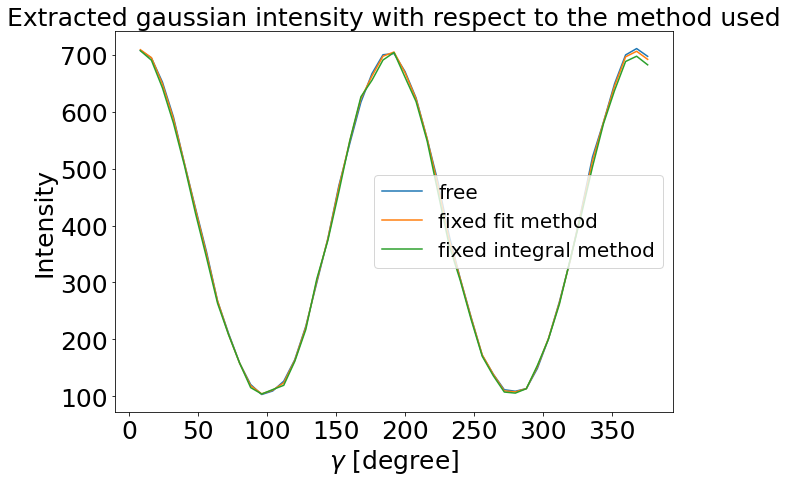

In [29]:
plt.figure(1, figsize=(10, 7))
plt.plot(L_polarisation_angle, L_intensity, label='free')
plt.plot(L_polarisation_angle, L_intensity_fit_gauss_fixed_para, label='fixed fit method')
plt.plot(L_polarisation_angle, L_intensity_integral_gauss_fixed_para, label='fixed integral method')
plt.xlabel(r'$\gamma$ [degree]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.title('Extracted gaussian intensity with respect to the method used', fontsize=25)
# plt.savefig(SAVE_DIR+'name_of_the_figure.pdf') # if you want to save the figure, uncomment this line

Text(0.5, 1.0, 'Incertitude relative')

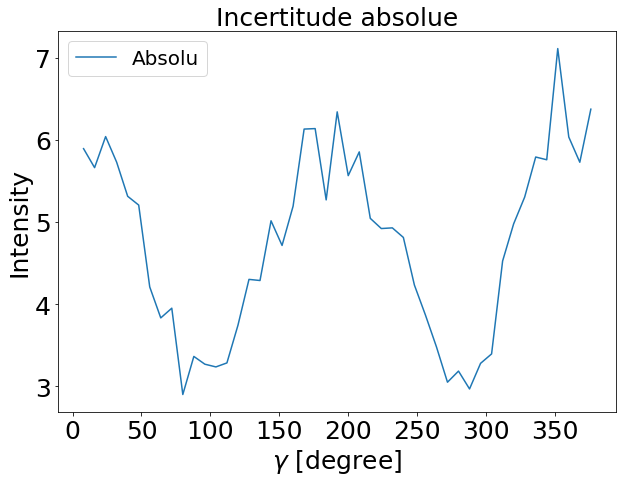

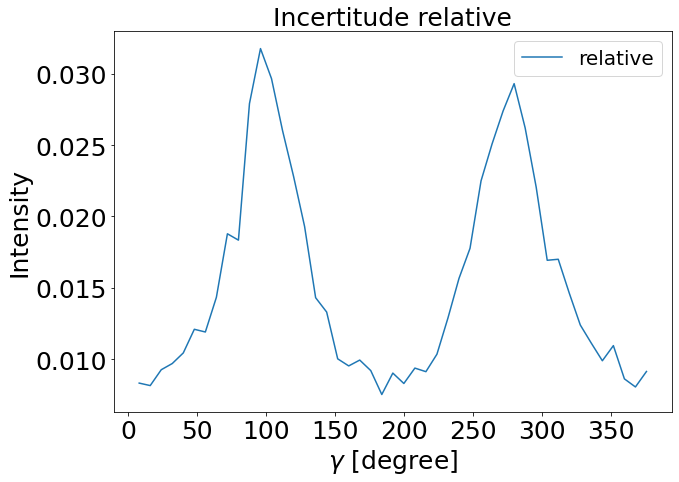

In [30]:
#Incertitude Intensity
plt.figure(1, figsize=(10, 7))
plt.plot(L_polarisation_angle, L_intensity_error, label='Absolu')
plt.xlabel(r'$\gamma$ [degree]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.title('Incertitude absolue', fontsize=25)


plt.figure(2, figsize=(10, 7))
plt.plot(L_polarisation_angle, L_intensity_error/L_intensity, label='relative')
plt.xlabel(r'$\gamma$ [degree]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.title('Incertitude relative', fontsize=25)

Text(0.5, 1.0, 'Intensity with error')

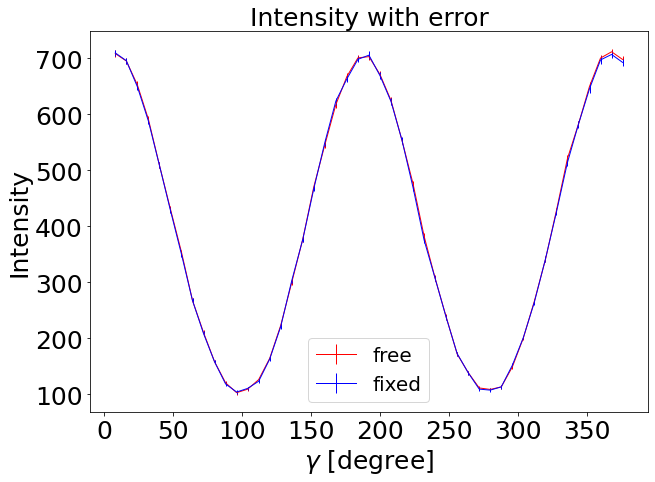

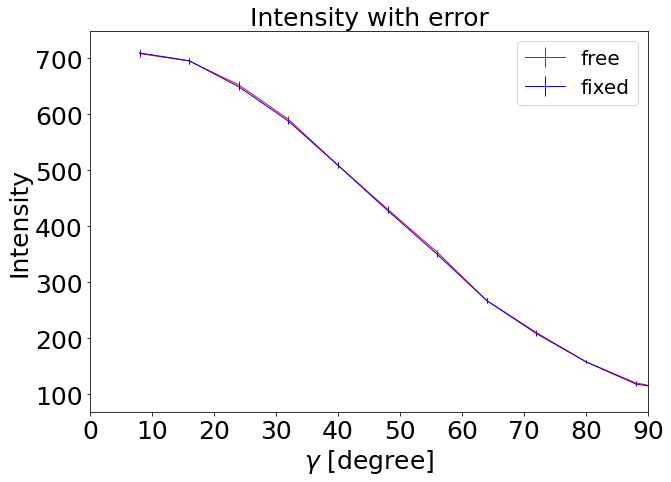

In [31]:
plt.figure(1, figsize=(10, 7))
plt.errorbar(L_polarisation_angle, L_intensity, yerr=L_intensity_error, label='free', fmt = 'r', marker='s', mfc='r',
          ms=0, mew=1, linewidth=1) 
plt.errorbar(L_polarisation_angle, L_intensity_fit_gauss_fixed_para, yerr=L_intensity_fit_gauss_fixed_para_error, label='fixed', fmt = 'b', marker='o', mfc='b',
          ms=0, mew=1, linewidth=1) 
plt.xlabel(r'$\gamma$ [degree]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.title('Intensity with error', fontsize=25)

plt.figure(2, figsize=(10, 7))
plt.errorbar(L_polarisation_angle, L_intensity, yerr=L_intensity_error, label='free', fmt = 'r', marker='s', mfc='r',
          ms=0, mew=1, linewidth=1) 
plt.errorbar(L_polarisation_angle, L_intensity_fit_gauss_fixed_para, yerr=L_intensity_fit_gauss_fixed_para_error, label='fixed', fmt = 'b', marker='o', mfc='b',
          ms=0, mew=1, linewidth=1) 
plt.xlabel(r'$\gamma$ [degree]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'Intensity', fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.xlim([0, 90])
plt.title('Intensity with error', fontsize=25)


Text(0.5, 1.0, '$\\lambda_0$ fit parameter found for every polarisation angle')

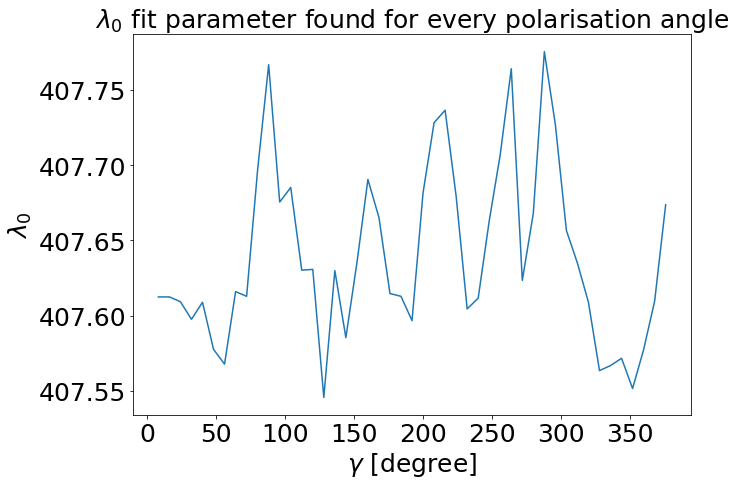

In [32]:
plt.figure(2, figsize=(10, 7))
plt.plot(L_polarisation_angle, L_lambda_0)
plt.xlabel(r'$\gamma$ [degree]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'$\lambda_0$', fontsize=25)
plt.yticks(fontsize=25)
plt.title(r'$\lambda_0$ fit parameter found for every polarisation angle', fontsize=25)


Text(0.5, 1.0, '$\\omega_0$ fit parameter found for every polarisation angle')

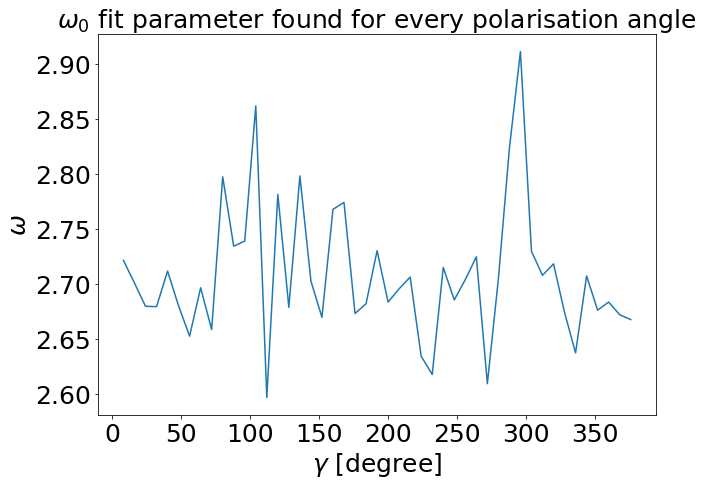

In [33]:
plt.figure(3, figsize=(10, 7))
plt.plot(L_polarisation_angle, L_waist)
plt.xlabel(r'$\gamma$ [degree]', fontsize=25)
plt.xticks(fontsize=25)
plt.ylabel(r'$\omega$', fontsize=25)
plt.yticks(fontsize=25)
plt.title(r'$\omega_0$ fit parameter found for every polarisation angle', fontsize=25)
